First, you need to run the corpus processing function. Before trying other data, we can use the (hard-coded) synthetic corpus in Gries. For this example, you'll need extra packages not in the requirements of the package: `statsmodels`, `patsy` and `seaborn`.

In [19]:
import mwu_measures
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import numpy as np
import seaborn as sns
mwu_measures.process_corpus(test_corpus=True)

This is what a preprocess corpus should look like.

In [26]:
list(mwu_measures.processing_corpus.BIGRAM_FW.items())

[('A',
  defaultdict(nltk.probability.FreqDist,
              {'a': FreqDist({'d': 1, 'y': 1, 'c': 1, 'x': 1}),
               'd': FreqDist({'c': 1}),
               'c': FreqDist({'b': 3, 'c': 1}),
               'b': FreqDist({'e': 1, 'f': 1, 'i': 1, 'n': 1, 'p': 1}),
               'e': FreqDist({'b': 1}),
               'f': FreqDist({'g': 1}),
               'g': FreqDist({'h': 1}),
               'h': FreqDist({'c': 1}),
               'i': FreqDist({'j': 1}),
               'j': FreqDist({'k': 1}),
               'k': FreqDist({'a': 1}),
               'y': FreqDist({'z': 1}),
               'z': FreqDist({'b': 1, 'n': 1}),
               'n': FreqDist({'o': 1, 'a': 1}),
               'o': FreqDist({'a': 1}),
               'p': FreqDist({'q': 1}),
               'q': FreqDist({'r': 1, 'a': 1}),
               'r': FreqDist({'q': 1, 'z': 1}),
               'x': FreqDist({'r': 1})})),
 ('B',
  defaultdict(nltk.probability.FreqDist,
              {'y': FreqDist({'i': 1, 'z': 1}

We can then easily compare the results from Gries' paper. These are the bigrams in tables 3 and 4. Note that entropy_2 in table 4 uses a different calculation, and is not supposed to match with the paper.
Also, because the author reports 1 - dispersion, I'll print it like that.

In [6]:
x = mwu_measures.get_mwu_scores(['b d', 'c b', 'a c'])
x['dispersion'] = 1 - x['dispersion']
x

,ngram,first,second,token_freq,dispersion,type_1,type_2,entropy_1,entropy_2,assoc_f,assoc_b
0,b d,b,d,3,0.199126,6,9,0.069372,0.029215,0.144810,0.243436
1,c b,c,b,5,0.811873,8,4,0.095055,0.225603,0.620430,0.404903
2,a c,a,c,2,0.565102,6,4,0.002592,0.039036,0.316464,0.239136


Now we can use real data and a real corpus. I used the BNC corpus because it's what I have at hand. This is currently the only corpus supported, but I'll add others soon. You have to get your own copy of the BNC. You put it in the main folder of the repository, where this file `(example.ipynb)` is. You can activate verbose mode to follow the processing status. It takes a while, as it's extracting all unigrams and bigrams of the corpus and computing their frequencies.

In [7]:
mwu_measures.process_corpus('bnc', 'bnc_tokenized.txt', chunk_size=100000, verbose=False)

We can take the multiword units from Muraki et al., 2022 (provided in the directory), from here: https://osf.io/ksypa/. For now, we can only use the bigrams. All bigrams not occurring in the BNC will be skipped.

In [9]:
mwu_examples = pd.read_csv('MultiwordExpression_Concreteness_Ratings.csv')
mwu_examples['length'] = mwu_examples['Expression'].apply(lambda x: len(x.split()))
mwu_examples = mwu_examples.loc[mwu_examples['length'] == 2]
mwu_examples['Expression'] = mwu_examples['Expression'].apply(lambda x: x.lower())
print(f'Number of possible bigrams: {len(mwu_examples)}')

Number of possible bigrams: 47486


On my test computer, this took around 6 minutes, including the normalization step. In my laptop, it was more like 15. We can see how many we had to skip because they're not in the corpus. If you're on Mac or Linux, you can use parallel processing to make it faster, although mileage may vary. From my tests, I've found that setting ncores to more than 4 diminishes the return on this specific task. For that, you just provide `parallel=TRUE` and `ncores=4` to the `get_mwu_scores` function. Read the function documentations to check the normalization part. Doesn't work very well with Windows, which is why I say it's supported only in MacOS and Linux.

In [11]:
mwu_scores = mwu_measures.get_mwu_scores(mwu_examples['Expression'], normalize=True, entropy_limits=[-0.1, 0.1], scale_entropy=True, verbose=False, track_progress=False, parallel=True, ncores=4)

c:\Users\contr\anaconda3\envs\mwu_measures\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Number of cores in use: 4


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:  8.2min remaining: 24.7min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  8.9min remaining:  8.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  9.7min finished


First time normalizing. Need to consolidate...


In [12]:
print(f'Bigrams that occur in BNC: {len(mwu_scores['normalized'])}')

Bigrams that occur in BNC: 32588


Let's do something very sloppy just as an illustration: relationship between concreteness and the MWU measures?

In [14]:
mwu_examples_filter = mwu_examples.loc[mwu_examples['Expression'].isin(list(mwu_scores['normalized']['ngram']))]
concreteness_mwu = pd.merge(mwu_examples_filter, mwu_scores['normalized'], how='left', left_on='Expression', right_on='ngram')
concreteness_mwu = concreteness_mwu.dropna()

In [15]:

y, X = dmatrices('Mean_C ~ token_freq + dispersion + type_1 + type_2 + entropy_1 + entropy_2 + assoc_f + assoc_b', data=concreteness_mwu, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Mean_C   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     846.3
Date:                Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                        18:15:54   Log-Likelihood:                -38588.
No. Observations:               31551   AIC:                         7.719e+04
Df Residuals:                   31542   BIC:                         7.727e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3158      0.066     20.048      0.0

Nice! We can also take an MWU score based on this. First we can take an average, and compare it with a weighted average. This will be part of the package shortly.

In [16]:
only_scores = concreteness_mwu[['token_freq', 'dispersion', 'type_1', 'type_2', 'entropy_1', 'entropy_2', 'assoc_f', 'assoc_b']]
concreteness_mwu['mwu_score'] = only_scores.mean(axis = 1)

<Axes: xlabel='mwu_score', ylabel='Mean_C'>

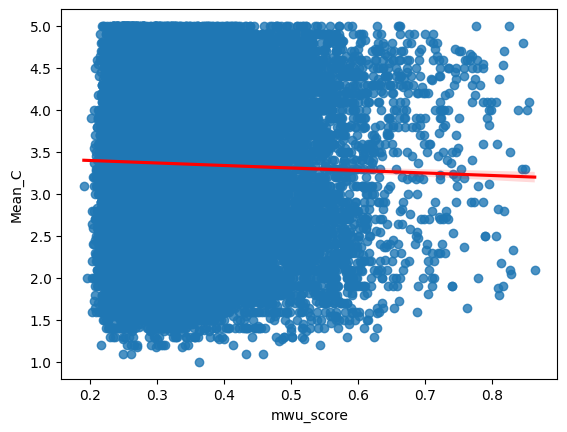

In [20]:
sns.regplot(x="mwu_score", y="Mean_C", data=concreteness_mwu, line_kws={"color": "red"})

And by providing different weights, we can generate an MWU score that prioritizes some dimensions over others.

In [23]:
concreteness_mwu['mwu_weighted_1'] = only_scores.apply(lambda x: np.average(x, weights=[0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]), axis=1)
concreteness_mwu['mwu_weighted_2'] = only_scores.apply(lambda x: np.average(x, weights=[0.1, 0.3, 0.05, 0.05, 0.2, 0.2, 0.05, 0.05]), axis=1)

<Axes: xlabel='mwu_weighted_1', ylabel='Mean_C'>

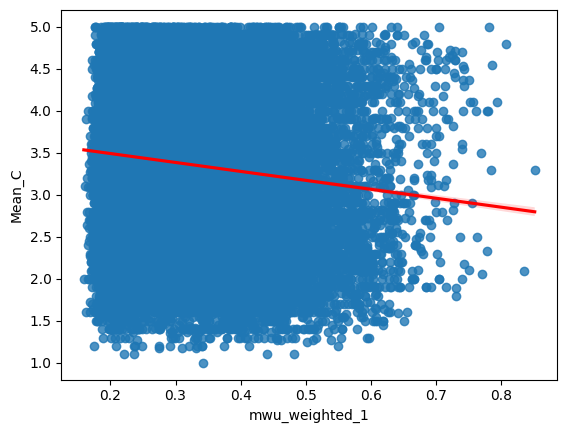

In [24]:
sns.regplot(x="mwu_weighted_1", y="Mean_C", data=concreteness_mwu, line_kws={"color": "red"})

<Axes: xlabel='mwu_weighted_2', ylabel='Mean_C'>

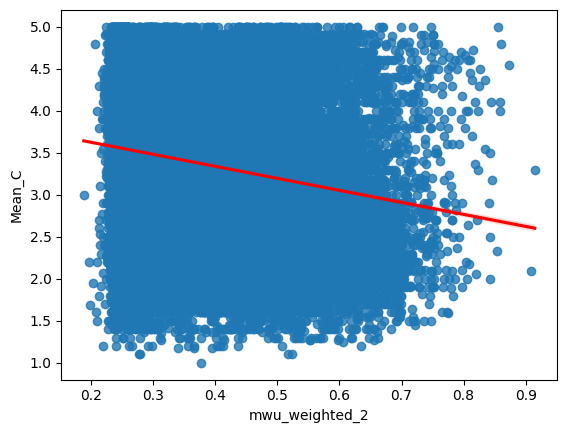

In [25]:
sns.regplot(x="mwu_weighted_2", y="Mean_C", data=concreteness_mwu, line_kws={"color": "red"})

Not the most interesting relationship, but it's a living. There you go!